In [17]:
import os
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random


In [21]:

# 데이터셋 폴더 경로 설정
data_folder = "C:/Workspace/LAB_DP/Week4/train"
test_folder = "C:/Workspace/LAB_DP/Week4/test"

# 데이터 전처리를 위한 변환 함수 정의
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_id = int(img_name[:4]) - 1  # 이미지 파일명의 첫 네 자리 숫자를 ID로 사용
        img_path = os.path.join(self.data_folder, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, img_id

# 사용자 정의 데이터셋 클래스 생성
custom_dataset = CustomDataset(data_folder, transform)
custom_testset = CustomDataset(test_folder, transform)

# 데이터셋 분할 (예시로 80% train, 10% test, 10% validation)
# 시드값 고정
random.seed(42)
train_size = int(0.8 * len(custom_dataset))
val_size = (len(custom_dataset) - train_size)
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
test_dataset = custom_testset

# DataLoader 생성
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


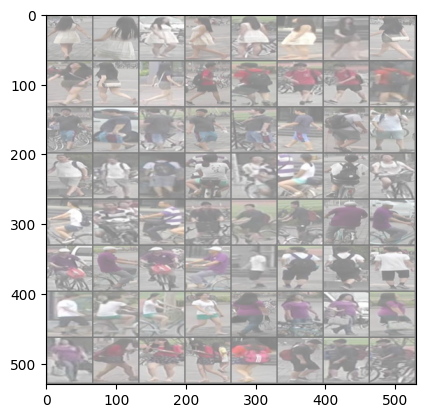

In [19]:

def imshow(img):
    img = img / 2 + 0.5  # 비정규화
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# train_loader에서 하나의 미니배치 추출
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 이미지 시각화
imshow(torchvision.utils.make_grid(images))


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cuda.matmul.allow_tf32 = True

# ResNet-18 모델 불러오기
model = models.resnet18(pretrained=True)  # 사전 훈련된 가중치를 사용하지 않음 (랜덤 초기화)
num_classes = 1501  # 데이터셋의 클래스 개수에 맞게 수정
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 학습 함수 구현
def train(model, epoch, optimizer, loss_function, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    for e in range(epoch):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {e+1}/{epoch}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {e+1}/{epoch}, Loss: {epoch_loss:.4f}")

        # Validation 정확도 계산
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        # GPU 메모리 정리
        torch.cuda.empty_cache()

# Test 함수 구현
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

# 모델 학습
learning_rate = 0.001
epoch = 10
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, epoch, optimizer, loss_function, train_loader, val_loader)

# 테스트 데이터로 모델 평가
test(model, test_loader)


c:\ProgramData\anaconda3\envs\UM\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\UM\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


Epoch 1/20: 100%|██████████| 326/326 [00:27<00:00, 12.03it/s]


Epoch 1/20, Loss: 6.2097
Validation Accuracy: 12.47%


Epoch 2/20: 100%|██████████| 326/326 [00:26<00:00, 12.21it/s]


Epoch 2/20, Loss: 3.1973
Validation Accuracy: 33.18%


Epoch 3/20: 100%|██████████| 326/326 [00:26<00:00, 12.19it/s]


Epoch 3/20, Loss: 1.7417
Validation Accuracy: 44.12%


Epoch 4/20: 100%|██████████| 326/326 [00:26<00:00, 12.19it/s]


Epoch 4/20, Loss: 1.0099
Validation Accuracy: 57.03%


Epoch 5/20: 100%|██████████| 326/326 [00:26<00:00, 12.17it/s]


Epoch 5/20, Loss: 0.6358
Validation Accuracy: 62.00%


Epoch 6/20: 100%|██████████| 326/326 [00:26<00:00, 12.14it/s]


Epoch 6/20, Loss: 0.4287
Validation Accuracy: 68.89%


Epoch 7/20: 100%|██████████| 326/326 [00:26<00:00, 12.23it/s]


Epoch 7/20, Loss: 0.2968
Validation Accuracy: 67.95%


Epoch 8/20: 100%|██████████| 326/326 [00:26<00:00, 12.21it/s]


Epoch 8/20, Loss: 0.2376
Validation Accuracy: 66.09%


Epoch 9/20: 100%|██████████| 326/326 [00:26<00:00, 12.28it/s]


Epoch 9/20, Loss: 0.2456
Validation Accuracy: 70.72%


Epoch 10/20: 100%|██████████| 326/326 [00:26<00:00, 12.22it/s]


Epoch 10/20, Loss: 0.1991
Validation Accuracy: 67.34%


Epoch 11/20: 100%|██████████| 326/326 [00:26<00:00, 12.23it/s]


Epoch 11/20, Loss: 0.2055
Validation Accuracy: 63.37%


Epoch 12/20: 100%|██████████| 326/326 [00:26<00:00, 12.24it/s]


Epoch 12/20, Loss: 0.1797
Validation Accuracy: 68.28%


Epoch 13/20: 100%|██████████| 326/326 [00:27<00:00, 11.96it/s]


Epoch 13/20, Loss: 0.1893
Validation Accuracy: 70.81%


Epoch 14/20: 100%|██████████| 326/326 [00:26<00:00, 12.24it/s]


Epoch 14/20, Loss: 0.1564
Validation Accuracy: 67.24%


Epoch 15/20: 100%|██████████| 326/326 [00:26<00:00, 12.17it/s]


Epoch 15/20, Loss: 0.1262
Validation Accuracy: 59.74%


Epoch 16/20: 100%|██████████| 326/326 [00:26<00:00, 12.21it/s]


Epoch 16/20, Loss: 0.1522
Validation Accuracy: 64.94%


Epoch 17/20: 100%|██████████| 326/326 [00:26<00:00, 12.08it/s]


Epoch 17/20, Loss: 0.1583
Validation Accuracy: 67.68%


Epoch 18/20: 100%|██████████| 326/326 [00:26<00:00, 12.20it/s]


Epoch 18/20, Loss: 0.1353
Validation Accuracy: 61.10%


Epoch 19/20: 100%|██████████| 326/326 [00:26<00:00, 12.20it/s]


Epoch 19/20, Loss: 0.1305
Validation Accuracy: 71.20%


Epoch 20/20: 100%|██████████| 326/326 [00:27<00:00, 11.97it/s]


Epoch 20/20, Loss: 0.0825
Validation Accuracy: 66.84%
Test Accuracy: 76.90%
